In [2]:
import os
import sys
import numpy as np

# Add the path to the custom library to the system path
sys.path.append('..')

# Import custom modules
from src import Tensor
from src.core.utils import data_analysis, context_manager
from src.architectures.transformer import Tokenizer, Transformer, DataLoader

### Constants and hyperparameters

In [3]:
# Constants
dataset_path = os.path.join(os.getcwd(), 'dataset', 'divina_commedia.txt')
tokenizer_path = os.path.join(os.getcwd(), 'checkpoints', 'tokenizer.json')
model_path = os.path.join(os.getcwd(), 'checkpoints', 'language_model')

In [4]:
# Hyperparameters
dropout = 0.2 # The dropout rate
train_val_split = 0.9 # 90% of the data will be used for training, 10% for validation
batch_size = 32 # The number of samples to use for each batch
grad_accumulation_steps = 1 # The number of steps to accumulate gradients before updating the model
sequence_length = 256 # The size of the sequence length (the context window)
learning_rate = 1e-3 # The learning rate for the optimizer
training_steps = 500 # The number of steps to train the model for
n_embed = 384 # The size of the token embeddings (the dimensionality of the embeddings)
eval_iters = 1 # The number of iterations to evaluate the model
n_attention_heads = 6 # The number of attention heads in the multi-head attention mechanism
n_decoder_blocks = 6 # The number of transformer'decoder blocks in the model

### Data loading

In [5]:
def load_txt_file(path: str) -> str:
    """
    Load a text file from the specified path.
    
    Parameters:
    - path (str): The path to the text file.
    
    Returns:
    - str: The contents of the text file.
    """
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f'The file "{path}" does not exist.')
    
    # Read the file
    with open(path, 'r', encoding='utf-8') as file:
        return file.read()

In [6]:
# Instantiate the tokenizer
tokenizer = Tokenizer()

# Load the state of the tokenizer
tokenizer.load(tokenizer_path)

# Extract the vocabulary size
vocab_size = tokenizer.get_vocab_size()

In [7]:
# Load the text file
text = load_txt_file(dataset_path)

# Encode the text using the tokenizer
encoded_text = tokenizer.encode(text)

# Convert the data to a tensor
data = Tensor(np.array(encoded_text), dtype=np.int32)

In [8]:
# Instantiate the data loader
data_loader = DataLoader(
    data = data, 
    train_val_split = train_val_split
)

### Building the model

In [9]:
# Create the language model
language_model = Transformer(
    name = "Language Model",
    vocab_size = vocab_size,
    n_embed = n_embed,
    n_attention_heads = n_attention_heads,
    sequence_length = sequence_length,
    n_decoder_blocks = n_decoder_blocks,
    dropout = dropout
)

### Initializing the model

In [10]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Get a batch of data
    x, _ = data_loader.get_batch(
        batch_size = batch_size,
        sequence_length = sequence_length
    )
    
    # Call the model with a batch of data to initialize it
    language_model(x)

In [11]:
# Display the model summary in tree format.
# This is useful since the whole model is composed of submodules,
# therefore, the model summary will be displayed recursively
language_model.summary(recursive=True)

Language Model (Transformer) [output_shape=(32, 256, 1024), params=11526400]
└── language_model.decoder (Decoder) [output_shape=(32, 256, 1024), params=11526400]
    ├── decoder.embedding (Embedding) [output_shape=(32, 256, 384), params=393216]
    ├── decoder.positional_embedding (Embedding) [output_shape=(256, 384), params=98304]
    ├── decoder.decoder_blocks (ModuleList) [output_shape=?, params=10639872]
    │   ├── module_list.0 (DecoderBlock) [output_shape=(32, 256, 384), params=1773312]
    │   │   ├── decoder_block.layer_norm_1 (LayerNormalization) [output_shape=(32, 256, 384), params=768]
    │   │   ├── decoder_block.mlp (MLP) [output_shape=(32, 256, 384), params=1181568]
    │   │   │   ├── mlp.dropout (Dropout) [output_shape=(32, 256, 384), params=0]
    │   │   │   ├── decoder_block.mlp.input_dense (Dense) [output_shape=(32, 256, 1536), params=591360]
    │   │   │   └── decoder_block.mlp.output_dense (Dense) [output_shape=(32, 256, 384), params=590208]
    │   │   ├── dec

### Training the model

In [12]:
# Train the model
history = language_model.fit(
    data_loader = data_loader,
    steps = training_steps,
    lr = learning_rate,
    batch_size = batch_size,
    eval_iters = eval_iters,
    grad_accumulation_steps = grad_accumulation_steps,
)

Step 1/500 | 217 tensors in memory | 4337.34 ms/step - Train Loss: 7.1238 | Validation loss: 7.1094
Step 2/500 | 222 tensors in memory | 4506.93 ms/step - Train Loss: 6.2630 | Validation loss: 6.2795
Step 3/500 | 222 tensors in memory | 4443.92 ms/step - Train Loss: 5.5033 | Validation loss: 5.4793
Step 4/500 | 222 tensors in memory | 4436.19 ms/step - Train Loss: 5.0870 | Validation loss: 5.0780
Step 5/500 | 222 tensors in memory | 4402.69 ms/step - Train Loss: 4.7548 | Validation loss: 4.7245
Step 6/500 | 222 tensors in memory | 4378.61 ms/step - Train Loss: 4.5381 | Validation loss: 4.5354
Step 7/500 | 222 tensors in memory | 4349.15 ms/step - Train Loss: 4.4761 | Validation loss: 4.4641
Step 8/500 | 222 tensors in memory | 4329.11 ms/step - Train Loss: 4.3880 | Validation loss: 4.4300
Step 9/500 | 222 tensors in memory | 4363.27 ms/step - Train Loss: 4.3219 | Validation loss: 4.3191
Step 10/500 | 222 tensors in memory | 4373.28 ms/step - Train Loss: 4.3475 | Validation loss: 4.2852

In [13]:
# Save the model
language_model.save(model_path)

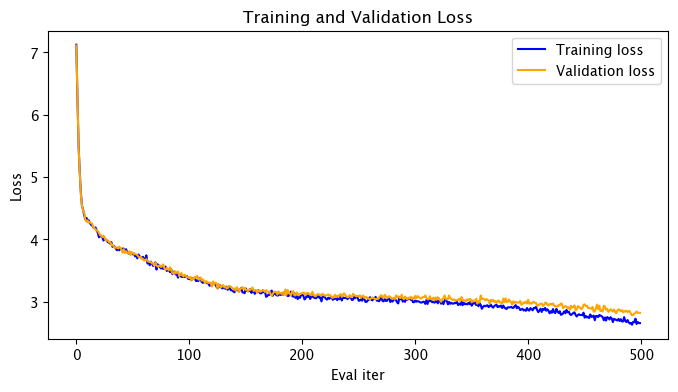

In [14]:
# Plot the training and validation loss
data_analysis.plot_history(history["loss"].data, history["val_loss"].data, "Training and Validation Loss", "Eval iter", "Loss")

### Inference

In [15]:
# Generate some text context from the trained model
context = Tensor(np.zeros((1, 1), dtype=np.int32))

# Iterate over the tokens generated by the transformer
for token in language_model.generate(context, max_new_tokens=200, stream=True):
    # Decode the token
    decoded_token = tokenizer.decode([token.data.squeeze().tolist()])

    # Print the decoded token
    print(decoded_token, end='', flush=True)

inva finseguralle
Santo di vien Stasta male,
come luce ed io io con que' quabbere,
Cadcome stringerbo che 'l si 'l enno more.
Ora e ora me si per monta si far questa acqua,
e finto ancor era ride,
semelle tristo, assi,
che rai le naturribile e chi perco;
quell'animo di fu e parti.
folsi crise omo?' crebbe trapparu veduro
cui,